In [1]:
# Dependencies and Setup
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
from scipy.stats import linregress
import scipy.stats as st

In [2]:
# Name of the CSV file, historical interest rate data was taken from 'https://www.rba.gov.au/statistics/historical-data.html' and saved as excel documentation.
file = 'Historical Interest Rate Data/Historical Interest Rate Data - 1990 - 2022.xlsx'

# Put the excel document into a dataframe
ir_df = pd.read_excel(file, sheet_name ='Sheet1', index_col=0, dtype={'Effective Date':'datetime64[ns]', 'Cash Rate Target': float})

#INPUTS: Create a list of the chosen dates and the timepoints from the chosen dates we want to analyse
peaks_date = ["1994-07-27","1999-10-05","2006-04-04","2007-07-03","2009-09-02"]
timepoint = [0,30,60,90,120,150,180]

#Empty to containers to be inputed for our dataframes
date_lst = []
timepoint_lst = []
nopeaks_lst = []
peaks_lst = []

# counter
i = 1

# Loop through all the defined peak dates, and for each each peaks dates populate the data with the timepoints defined.
for dt in peaks_date:
    startdate = datetime.strptime(dt, '%Y-%m-%d')
    for t in range(len(timepoint)):
        if timepoint[t] == 0:
            enddate = startdate 
        else: enddate = startdate + timedelta(days=timepoint[t])
        #Make sure dates doesn't land on Weekends
        if enddate.weekday() > 4:
            #print(enddate)
            if enddate.weekday() == 5:
                enddate = enddate + timedelta(days=3)
            else: enddate = enddate + timedelta(days=2)
        
        # append the peak number, timepoint and dates into the empty list containers.
        peaks_lst.append(enddate)
        timepoint_lst.append(timepoint[t])
        nopeaks_lst.append(i)
        t += 1
    i += 1

# Dataframe of dates of interest and it's corresponding peaks and timepoint
peaks_df = pd.DataFrame({'Peak':nopeaks_lst,'Timepoint': timepoint_lst,'Date': peaks_lst})
peaks_df.head(7)


,Peak,Timepoint,Date
0,1,0,1994-07-27
1,1,30,1994-08-26
2,1,60,1994-09-27
3,1,90,1994-10-25
4,1,120,1994-11-24
5,1,150,1994-12-27
6,1,180,1995-01-23


In [3]:
# Using Pandas grouping to group the data by Peaks
peaks_grouped = peaks_df.groupby('Peak')
# Get series of the first value of the group index
startdt_lst = peaks_grouped['Date'].first()
# Get series of the Last value of the group index
enddt_lst =  peaks_grouped['Date'].last()

In [4]:
# Create a function to make a mask
def Inbetween_(start_date, end_date):
    mask = (ir_df.index > start_date) & (ir_df.index <= end_date)
    return mask 

# Data Splice to different group
Peak_1 = ir_df[Inbetween_(startdt_lst.values[0],enddt_lst.values[0])]
Peak_2 = ir_df[Inbetween_(startdt_lst.values[1],enddt_lst.values[1])]
Peak_3 = ir_df[Inbetween_(startdt_lst.values[2],enddt_lst.values[2])]
Peak_4 = ir_df[Inbetween_(startdt_lst.values[3],enddt_lst.values[3])]
Peak_5 = ir_df[Inbetween_(startdt_lst.values[4],enddt_lst.values[4])]


In [5]:
# GETTING ASX STOCK DATA from Yahoo using module 'Pandas DataReader'

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '1991-01-01'
end_date = '2021-12-31'

# Call up Pandas DataReader function
panel_data = data.DataReader('^AXJO', 'yahoo', start_date, end_date)

# Create a function to make a mask for our range dates. 
def Inbetween_(start_date, end_date,df):
    mask = (df.index > start_date) & (df.index <= end_date)
    return mask 

# Splice data to match the chosen dates of the IR.
Stock_Peak_1 = panel_data[Inbetween_(startdt_lst.values[0],enddt_lst.values[0],panel_data)]
Stock_Peak_2 = panel_data[Inbetween_(startdt_lst.values[1],enddt_lst.values[1],panel_data)]
Stock_Peak_3 = panel_data[Inbetween_(startdt_lst.values[2],enddt_lst.values[2],panel_data)]
Stock_Peak_4 = panel_data[Inbetween_(startdt_lst.values[3],enddt_lst.values[3],panel_data)]
Stock_Peak_5 = panel_data[Inbetween_(startdt_lst.values[4],enddt_lst.values[4],panel_data)]

# Save plot 
panel_data.to_csv('panel_data.csv')

# Put everything in the list for easy access for looping purposes later on analysis
IR_peak_lst = [Peak_1,Peak_2,Peak_3,Peak_4,Peak_5]
ASX_peak_lst = [Stock_Peak_1,Stock_Peak_2,Stock_Peak_3,Stock_Peak_4,Stock_Peak_5]

In [6]:
#Re-instate new dataframe for our ASX data
ASXpeaks_df = peaks_df

#Empty containers and counter
close_price = []
i = 0
j = 1

# Loop through the dates and find its corresponding closed price 
for dt_ in ASXpeaks_df['Date']: 
    # As the market is close on weekends & national public holiday, error catch to get the last defined date (7 days chosen as market never closed more than 5 day consecutively)
    try: 
        price_ = panel_data['Close'][panel_data.index == dt_].values[0]
    except:
        price_ = 0
        if price_ == 0: 
            for j in range(7):
                try:
                    price_ = panel_data['Close'][panel_data.index == (dt_ - timedelta(days=j))].values[0]
                except:
                    price_ = 0
                
                if price_ != 0:
                    price_ = price_
                    break
            j += 1
    
    close_price.append(price_)

#Insert price column into our ASX dataframe
ASXpeaks_df['ASX'] = close_price

In [7]:
# Formula % difference function 
def d_percentage(new,old):
    try:
        d_percentage = ((new - old) /old) 
    except:
        d_percentage = 0
    return d_percentage

#New dataframe to only have timepoint 0
old_price_peak = ASXpeaks_df.loc[ASXpeaks_df['Timepoint'] == 0].reset_index()

# Re-instate counter
i = 0
j = 1
change = []

# Populate list of percentage difference of each timepoint corresponding to its peak startdate using the define function above
for price in ASXpeaks_df['ASX']:
    if ASXpeaks_df['Peak'].values[i] == 1:
        a = d_percentage(price,old_price_peak['ASX'].values[0])
    elif ASXpeaks_df['Peak'].values[i] == 2:
        a = d_percentage(price,old_price_peak['ASX'].values[1])
    elif ASXpeaks_df['Peak'].values[i] == 3:
        a = d_percentage(price,old_price_peak['ASX'].values[2])
    elif ASXpeaks_df['Peak'].values[i] == 4:
        a = d_percentage(price,old_price_peak['ASX'].values[3])
    elif ASXpeaks_df['Peak'].values[i] == 5:
        a = d_percentage(price,old_price_peak['ASX'].values[4])
    change.append(a)
    i += 1

#Creates a new column to store the change difference from timepoint 0 to 'i' time point 
ASXpeaks_df['Percentage Change'] = change

# ANALYSIS
Plotting charts and finding its correlation

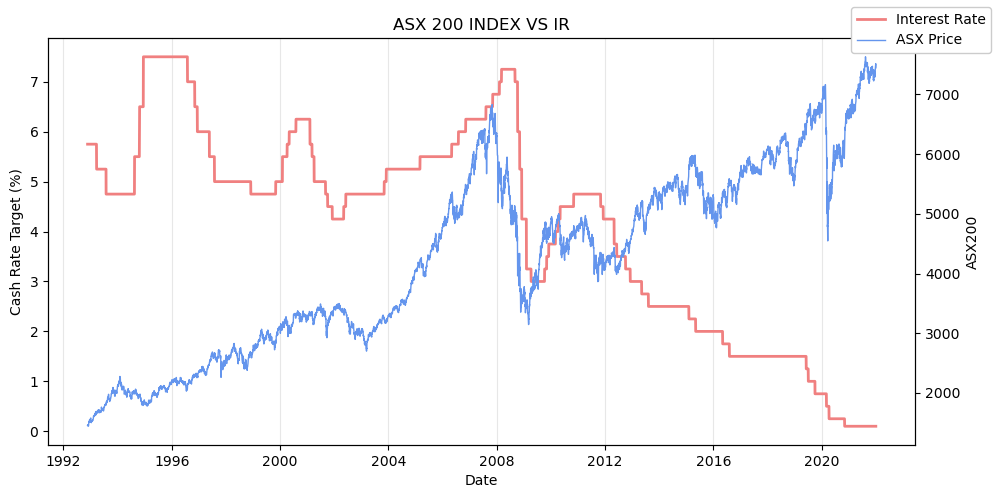

In [35]:
#Combine plot of ASX and interest rate (PLOT ALL DATA COLLECTED)
plt.style.use('default')

fig, ax1 = plt.subplots()

ax1.plot(ir_df, color = 'lightcoral', lw=2,label='Interest Rate')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cash Rate Target (%)')
ax1.tick_params(axis='y')
ax1.grid(axis='x', alpha=0.3)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(panel_data['Close'], lw =1,color ='cornflowerblue',label='ASX Price')
ax2.set_ylabel('ASX200')  # we already handled the x-label with ax1
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(facecolor = 'w', framealpha = 1)
fig.set_size_inches(10,5)
plt.title(f"ASX 200 INDEX VS IR")
plt.tight_layout()

plt.savefig(f"Chart Combine.png")


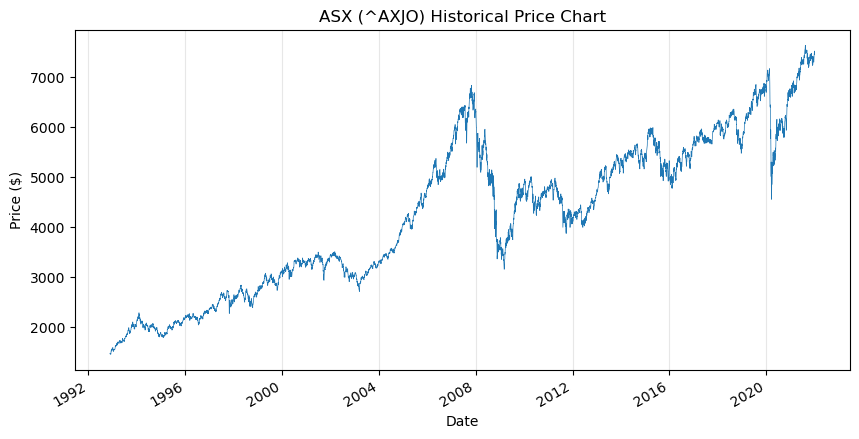

In [34]:
# Plot ASX Data
ax = panel_data['Close'].plot(figsize=(10, 5), use_index=True, ylabel='Price ($)',lw=0.5)
ax.set_title('ASX (^AXJO) Historical Price Chart')
ax.grid(axis='x', alpha=0.3)
fig = ax.get_figure()
fig.savefig("ASX CHART")

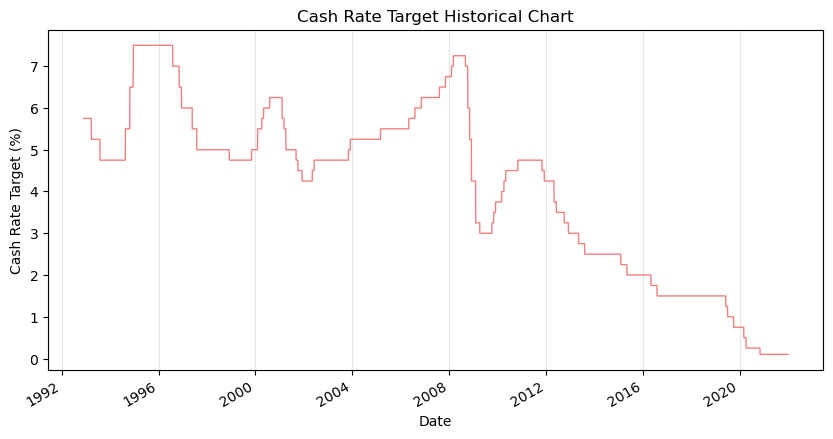

In [33]:
# Plot Interest Rate Data
ax = ir_df.plot(label='Cash',color = 'lightcoral', lw=1)
ax.set_title('Cash Rate Target Historical Chart')
ax.set_ylabel('Cash Rate Target (%)')
ax.set_xlabel('Date')
ax.get_legend().remove()
ax.grid(axis='x', alpha=0.3)
fig = ax.get_figure()
fig.set_size_inches(10,5)
fig.savefig("IR CHART")

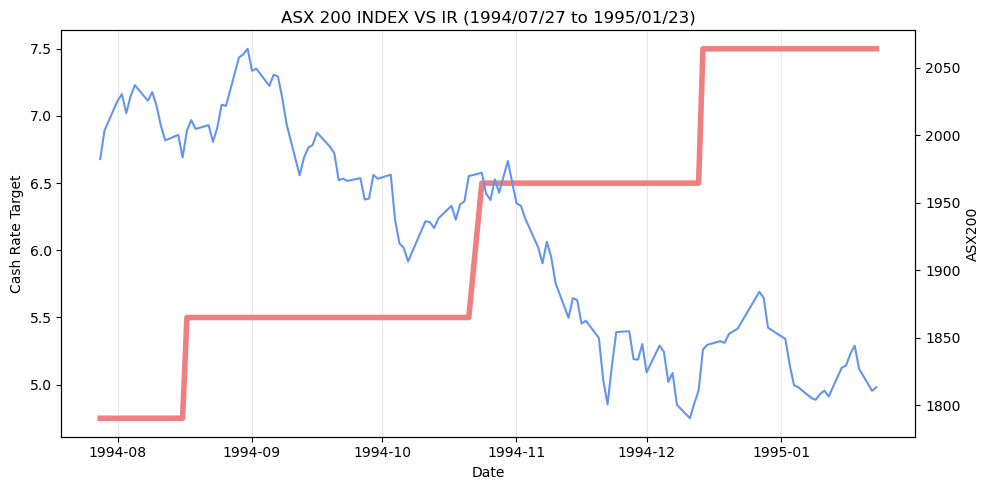

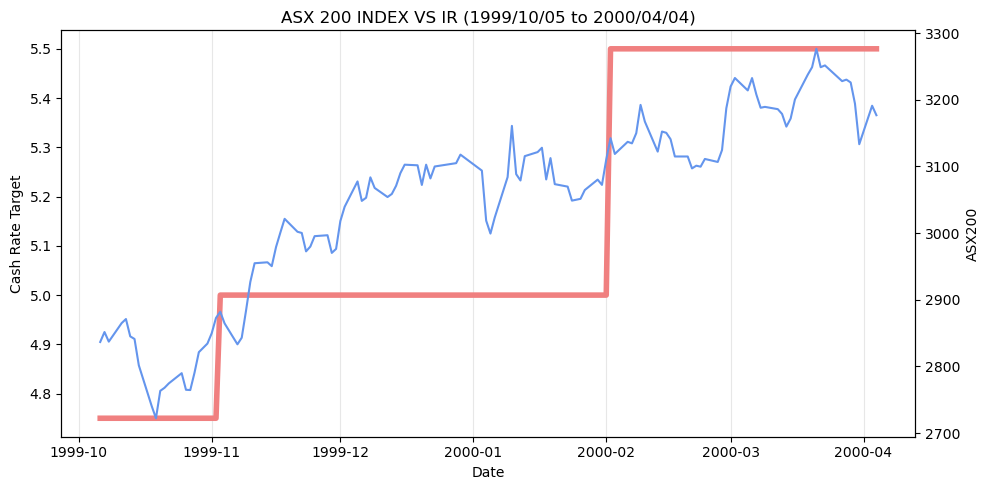

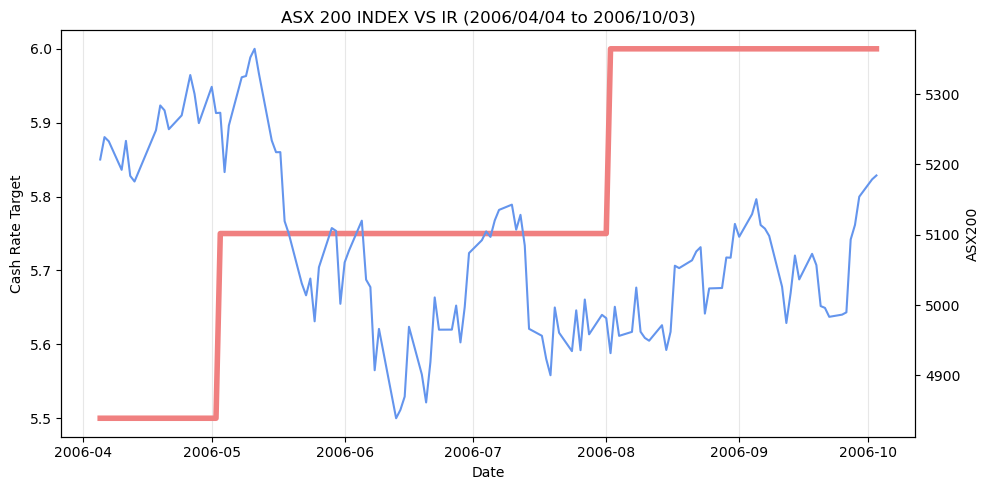

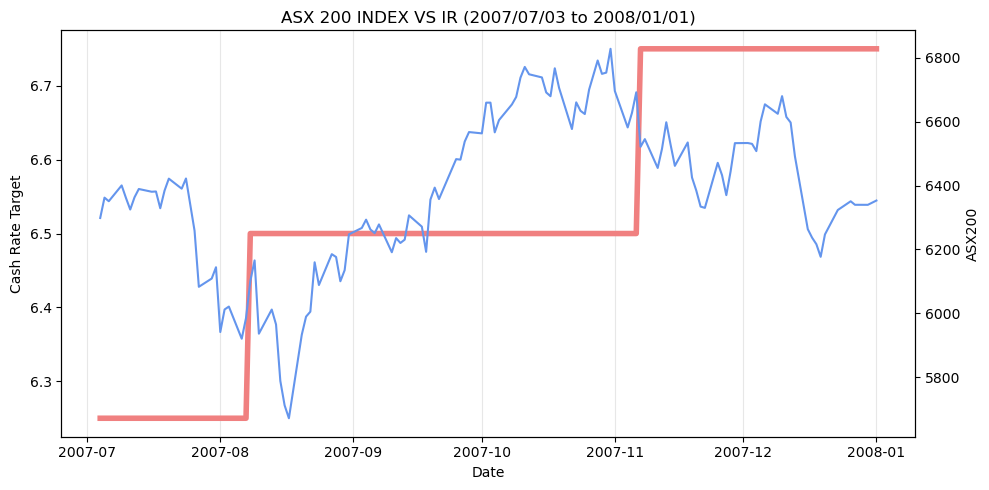

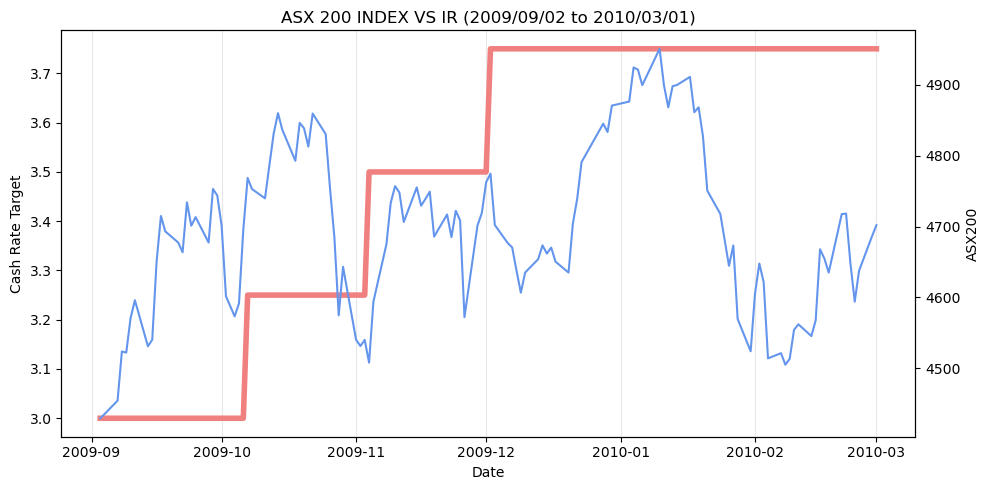

In [10]:
# Define a function to plot similar chart (Interest rate plot vs ASX plot at the date range we've specified)
def plot_peaks(df_IR,df_peak,i):
    
    #Start Date and End date
    end_date = pd.to_datetime(enddt_lst.values[i])
    end_date = end_date.strftime('%Y/%m/%d')
   
    start_date = pd.to_datetime(startdt_lst.values[i])
    start_date = start_date.strftime('%Y/%m/%d')

    plt.style.use('default')

    fig, ax1 = plt.subplots()

    ax1.plot(df_IR, color = 'lightcoral', lw=4)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cash Rate Target')
    ax1.tick_params(axis='y')
    ax1.grid(axis='x', alpha=0.3)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.plot(df_peak['Close'], color ='cornflowerblue')
    ax2.set_ylabel('ASX200')  # we already handled the x-label with ax1
    ax2.tick_params(axis='y')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.set_size_inches(10,5)
    plt.title(f"ASX 200 INDEX VS IR ({start_date} to {end_date})")
    plt.tight_layout()

    plt.savefig(f"Chart {i}.png")

#Define Counter
i = 0

# Iterate through the peaks we have chosen, create,show and print charts.
for i in range(len(IR_peak_lst)):
    plot_peaks(IR_peak_lst[i],ASX_peak_lst[i],i)
    i += 1

The correlation coefficient between the Time Period and Percentage Change is 0.19


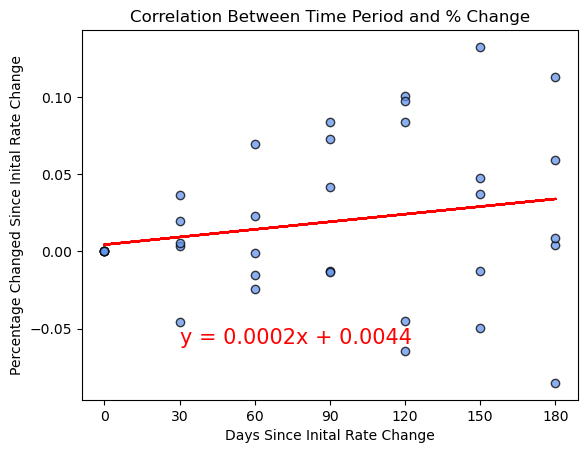

In [11]:
# # #---------------
# # Calculate the linear regression
x_values = ASXpeaks_df['Timepoint']
y_values = ASXpeaks_df['Percentage Change']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,4))

# Plot the data
plt.scatter(x_values,y_values, marker="o", facecolors="cornflowerblue", edgecolors="black", alpha=0.75)
plt.plot(x_values,regress_values,"r-")
plt.xticks(ticks=[0, 30, 60, 90, 120, 150, 180])
plt.annotate(line_eq,(30,-0.06),fontsize=15,color="red")
plt.xlabel("Days Since Inital Rate Change")
plt.ylabel("Percentage Changed Since Inital Rate Change")
plt.title("Correlation Between Time Period and % Change")
plt.savefig("PyPlot_Scatter - Correlation.png");

# Calculate and print the correlation coefficent 
print(f"The correlation coefficient between the Time Period and Percentage Change is {round(st.pearsonr(ASXpeaks_df['Timepoint'],ASXpeaks_df['Percentage Change'])[0],2)}")

In [36]:
# Store to new dataframe for formatting 
ASXpeaks_df1 = ASXpeaks_df
ASXpeaks_df1
#Format Findings 
ASXpeaks_df1["Percentage Change"] = ASXpeaks_df1["Percentage Change"].astype(float).map("{:,.2%}".format)
ASXpeaks_df1["ASX"] = ASXpeaks_df1["ASX"].astype(float).map("{:,.2f}".format)
#Save as .CSV
ASXpeaks_df1.to_csv('Percentage Change ASX')
ASXpeaks_df1

,Peak,Timepoint,Date,ASX,Percentage Change
0,1,0,1994-07-27,"1,982.20",0.00%
1,1,30,1994-08-26,"2,021.60",1.99%
2,1,60,1994-09-27,"1,952.30",-1.51%
3,1,90,1994-10-25,"1,956.60",-1.29%
4,1,120,1994-11-24,"1,854.20",-6.46%
5,1,150,1994-12-27,"1,884.00",-4.95%
6,1,180,1995-01-23,"1,813.40",-8.52%
7,2,0,1999-10-05,"2,854.60",0.00%
8,2,30,1999-11-04,"2,864.60",0.35%
9,2,60,1999-12-07,"3,053.00",6.95%
